In [1]:
import os
import sys

from transformers import MBartForConditionalGeneration, AutoTokenizer
import torch
from torch import nn
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import wandb
import html
import random

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample

!pip install underthesea --quiet
from underthesea import word_tokenize

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
model = MBartForConditionalGeneration.from_pretrained("mc0c0z/BARTPho-Large-multi-task")
tokenizer = AutoTokenizer.from_pretrained("mc0c0z/BARTPho-Large-multi-task")
model.to(device)

config.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(64001, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(64001, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (fina

# Data Preparing

In [4]:
train_vlsp_2016 = pd.read_csv('/kaggle/input/vlsp-2016/train.csv')
train_aivivn_2019 = pd.read_csv('/kaggle/input/aivivn-2019/train.csv')

test_vlsp_2016 = pd.read_csv('/kaggle/input/vlsp-2016/test.csv')
test_aivivn_2019 = pd.read_csv('/kaggle/input/aivivn-2019/test.csv')

In [5]:
train_sa_data = pd.concat([train_aivivn_2019, train_vlsp_2016])
label_0 = train_sa_data[train_sa_data['label'] == 0]
label_1 = train_sa_data[train_sa_data['label'] == 1]

# Tính số lượng mẫu cho mỗi nhãn
n_samples = 10000 // 2

# Sample từ mỗi nhóm
sampled_0 = resample(label_0, n_samples=n_samples, replace=False, random_state=17)
sampled_1 = resample(label_1, n_samples=n_samples, replace=False, random_state=9)

# Kết hợp các mẫu đã lấy
balanced_sample = pd.concat([sampled_0, sampled_1])

# Xáo trộn dữ liệu
train_sa_data = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)
train_sa_data = train_sa_data.drop(columns='id').rename(columns={'comment': 'source', 'label': 'target'})

# Chia dữ liệu train thành train:val = 90:10
train_sa_data, val_sa_data = train_test_split(train_sa_data, test_size=0.1, random_state=42)

test_vlsp_2016 = test_vlsp_2016.rename(columns={'comment': 'source', 'label': 'target'})
test_aivivn_2019 = test_aivivn_2019.rename(columns={'comment': 'source', 'label': 'target'})

In [6]:
vi_train_dataset = pd.read_csv("/kaggle/input/en-vi-small/train/train.vi", sep='\t', header=None)
en_train_dataset = pd.read_csv("/kaggle/input/en-vi-small/train/train.en", sep='\t', header=None)

vi_val_dataset = pd.read_csv("/kaggle/input/en-vi-small/val/tst2012.vi", sep='\t', header=None)
en_val_dataset = pd.read_csv("/kaggle/input/en-vi-small/val/tst2012.en", sep='\t', header=None)

vi_test_dataset = pd.read_csv("/kaggle/input/en-vi-small/test/tst2013.vi", sep='\t', header=None)
en_test_dataset = pd.read_csv("/kaggle/input/en-vi-small/test/tst2013.en", sep='\t', header=None)

# Limit train data to 10000 samples
# vi_train_dataset = vi_train_dataset.sample(n=10000, random_state=42).reset_index(drop=True)
# en_train_dataset = en_train_dataset.sample(n=10000, random_state=42).reset_index(drop=True)

# Limit val and test data to 1000 samples
vi_val_dataset = vi_val_dataset.sample(n=1000, random_state=42).reset_index(drop=True)
en_val_dataset = en_val_dataset.sample(n=1000, random_state=42).reset_index(drop=True)

vi_test_dataset = vi_test_dataset.sample(n=1000, random_state=42).reset_index(drop=True)
en_test_dataset = en_test_dataset.sample(n=1000, random_state=42).reset_index(drop=True)

In [7]:
# Tạo train_mt_data
train_mt_en_vi_data = pd.DataFrame({
    'source': en_train_dataset[0],
    'target': vi_train_dataset[0]
}).sample(n=10000, random_state=2)

train_mt_vi_en_data = pd.DataFrame({
    'source': vi_train_dataset[0],
    'target': en_train_dataset[0]
}).sample(n=10000, random_state=40)

# Tạo val_mt_data
val_mt_en_vi_data = pd.DataFrame({
    'source': en_val_dataset[0],
    'target': vi_val_dataset[0]
})

val_mt_vi_en_data = pd.DataFrame({
    'source': vi_val_dataset[0],
    'target': en_val_dataset[0]
})

# Tạo test_mt_data
test_mt_en_vi_data = pd.DataFrame({
    'source': en_test_dataset[0],
    'target': vi_test_dataset[0]
})

test_mt_vi_en_data = pd.DataFrame({
    'source': vi_test_dataset[0],
    'target': en_test_dataset[0]
})

In [8]:
# Thêm cột 'task' để phân biệt giữa SA và MT
train_sa_data['task'] = 'sa'
train_mt_en_vi_data['task'] = 'mt-en-vi'
train_mt_vi_en_data['task'] = 'mt-vi-en'

train_data = pd.concat([train_sa_data, train_mt_en_vi_data, train_mt_vi_en_data], ignore_index=True)
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

val_sa_data['task'] = 'sa'
val_mt_en_vi_data['task'] = 'mt-en-vi'
val_mt_vi_en_data['task'] = 'mt-vi-en'

val_data = pd.concat([val_sa_data, val_mt_en_vi_data, val_mt_vi_en_data], ignore_index=True)
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Create Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, word_tokenize):
        self.tokenizer = tokenizer
        self.word_tokenize = word_tokenize
        self.data = dataframe
    
    def get_prompt(self, task):
        if task == 'sa':
            return "Classify the sentiment: "
        elif task == 'mt-en-vi':
            return "Translate English to Vietnamese: "
        elif task == 'mt-vi-en':
            return "Translate Vietnamese to English: "
        else:
            return "" 
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        task = row['task']
        prompt = self.get_prompt(task)
        
        tokenized_text = self.word_tokenize(str(row['source']))
        source = prompt + " ".join(tokenized_text)
        target = str(row['target'])

        sources = self.tokenizer(source, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        targets = self.tokenizer(target, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

        return {
            "input_ids": sources["input_ids"][0],
            "attention_mask": sources["attention_mask"][0],
            "labels": targets["input_ids"][0]
        }

    def __len__(self):
        return len(self.data)

In [10]:
def segmenter(text):
    text = html.unescape(text)
    tokens = word_tokenize(text)
    result = []
    for token in tokens:
        if ' ' in token:
            result.append(token.replace(' ', '_'))
        else:
            result.append(token)
    return result

In [11]:
# Create multi task dataset
train_dataset = CustomDataset(train_data, tokenizer, segmenter)
val_dataset = CustomDataset(val_data, tokenizer, segmenter)

# Training

In [12]:
from kaggle_secrets import UserSecretsClient

# Tự động nhập API key từ Kaggle Secret
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value_0)

# # Đặt cấu hình cho wandb
wandb.init(project="BTL NLP BERT", name="BARTPho large SA+MT2 + 30k next")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mc0c0z. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240801_164559-j4ebtxjc
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run BARTPho large SA+MT2 + 30k next
wandb: ⭐️ View project at https://wandb.ai/mc0c0z/BTL%20NLP%20BERT
wandb: 🚀 View run at https://wandb.ai/mc0c0z/BTL%20NLP%20BERT/runs/j4ebtxjc


In [13]:
from transformers import Trainer, TrainingArguments

# Training parameters
training_args = TrainingArguments(
    output_dir='./results',
    run_name="BARTPho_finetuning_SA+MT2",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=237,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="wandb",
    gradient_accumulation_steps=5,
    learning_rate=3e-5,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

2024-08-01 16:46:17.719608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 16:46:17.719715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 16:46:17.857253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
0,0.385300,0.310576
1,0.350000,0.301468
2,0.302600,0.297466
3,0.264700,0.297897
5,0.204700,0.304884
6,0.187800,0.308223
7,0.166100,0.311461
8,0.159500,0.313950
9,0.148300,0.315066


TrainOutput(global_step=3620, training_loss=0.23800936456543306, metrics={'train_runtime': 18019.5634, 'train_samples_per_second': 16.094, 'train_steps_per_second': 0.201, 'total_flos': 7.843059343137178e+16, 'train_loss': 0.23800936456543306, 'epoch': 9.983452840595698})

# Upload model to huggingface

In [15]:
secret_value_1 = user_secrets.get_secret("huggingface_token")
!huggingface-cli login --token $secret_value_1 --add-to-git-credential

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [16]:
model.push_to_hub("mc0c0z/BARTPho-Large-multi-task")
tokenizer.push_to_hub("mc0c0z/BARTPho-Large-multi-task")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mc0c0z/BARTPho-Large-multi-task/commit/dbf2b7c1e912bcd502f173866c003a9c7acf1c79', commit_message='Upload tokenizer', commit_description='', oid='dbf2b7c1e912bcd502f173866c003a9c7acf1c79', pr_url=None, pr_revision=None, pr_num=None)

# Testing

In [17]:
def inference(prompt, text, device):
    text = prompt + " ".join(segmenter(text))
    inputs = tokenizer(text, max_length=128, truncation=True, return_tensors="pt").input_ids.to(device)
    preds = model.generate(inputs, max_length=128, num_beams=1)
    decoded_preds = tokenizer.batch_decode(sequences=preds, skip_special_tokens=True)

    return decoded_preds

prompt = {
    'sa': 'Classify the sentiment: ',
    'mt-en-vi': 'Translate English to Vietnamese: ',
    'mt-vi-en': 'Translate Vietnamese to English: '
}
print(inference(prompt['sa'], "This movie is bad.", device))
print(inference(prompt['mt-en-vi'], "This movie is bad.", device))
print(inference(prompt['mt-vi-en'], "Bộ phim này tệ.", device))

['0']
['Phim này dở.']
['This film is bad.']


In [18]:
def generate_predictions(model, dataset, device, batch_size=32):
    model.eval()
    predictions = []
    targets = []
    inputs = []
    
    # Tạo DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            generated_outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=128)
            batch_predictions = tokenizer.batch_decode(generated_outputs, skip_special_tokens=True)
            
            batch_targets = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
            
            predictions.extend(batch_predictions)
            targets.extend(batch_targets)
            inputs.extend(input_ids.tolist())
    
    return inputs, targets, predictions

In [19]:
test_vlsp_2016 = test_vlsp_2016[test_vlsp_2016['target'] != 2]
test_vlsp_2016.loc[:, 'task'] = 'sa'
test_aivivn_2019.loc[:, 'task'] = 'sa'

# Tạo dataloader cho tập test VLSP 2016
test_vlsp_2016_dataloader = CustomDataset(test_vlsp_2016, tokenizer, segmenter)
test_aivivn_2019_dataloader = CustomDataset(test_aivivn_2019, tokenizer, segmenter)

100%|██████████| 746/746 [03:13<00:00,  3.86it/s]


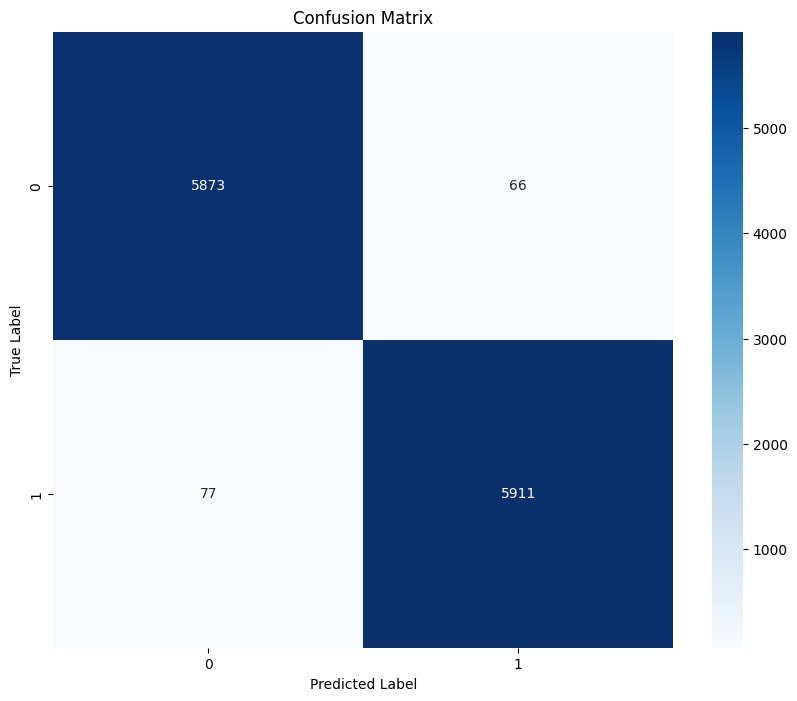

Classification Report:
              precision    recall  f1-score   support

           0     0.9871    0.9889    0.9880      5939
           1     0.9890    0.9871    0.9880      5988

    accuracy                         0.9880     11927
   macro avg     0.9880    0.9880    0.9880     11927
weighted avg     0.9880    0.9880    0.9880     11927



In [20]:
def report_sa_task(targets, predictions):
    # Chuyển đổi nhãn từ chuỗi sang số
    label_map = {'0': 0, '1': 1, '2': 2}
    predictions = [label_map.get(p[0], -1) if p else -1 for p in predictions]  # -1 cho các giá trị không hợp lệ
    true_labels = [label_map.get(t, -1) for t in targets]
    
    # Loại bỏ các cặp dự đoán và nhãn không hợp lệ
    valid_pairs = [(p, t) for p, t in zip(predictions, true_labels) if p != -1 or t != -1]
    if valid_pairs:
        predictions, true_labels = zip(*valid_pairs)
    else:
        print("Không có dự đoán hợp lệ nào.")
        return
    
    # Tạo confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    unique_labels = sorted(set(true_labels + predictions))
    # Vẽ heatmap cho confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # In ra classification report
    report = classification_report(true_labels, predictions, digits=4)
    print("Classification Report:")
    print(report)

_, targets, predictions = generate_predictions(model, test_vlsp_2016_dataloader, device, batch_size=16)
report_sa_task(targets, predictions)

100%|██████████| 202/202 [00:50<00:00,  4.01it/s]


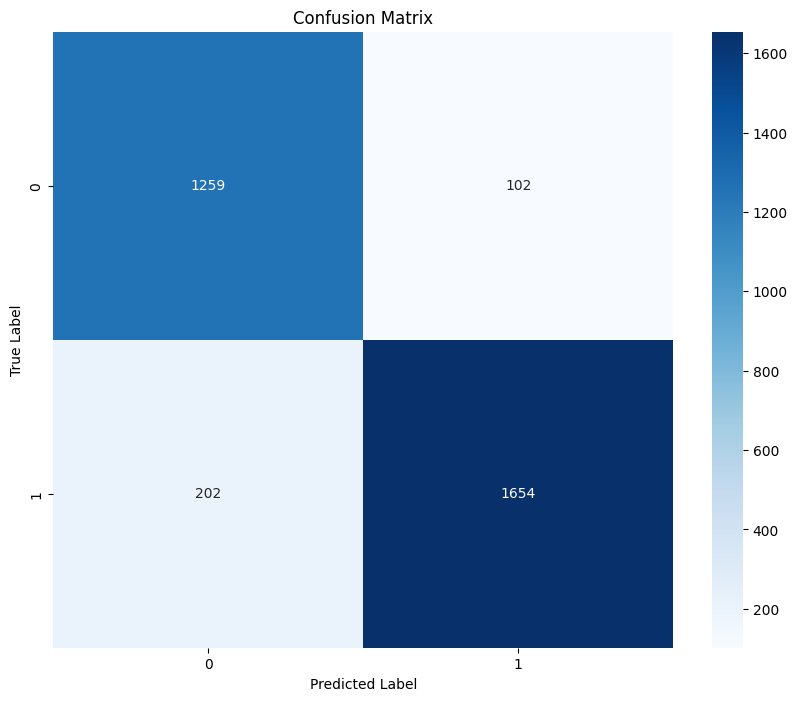

Classification Report:
              precision    recall  f1-score   support

           0     0.8617    0.9251    0.8923      1361
           1     0.9419    0.8912    0.9158      1856

    accuracy                         0.9055      3217
   macro avg     0.9018    0.9081    0.9041      3217
weighted avg     0.9080    0.9055    0.9059      3217



In [21]:
_, targets, predictions = generate_predictions(model, test_aivivn_2019_dataloader, device, batch_size=16)
report_sa_task(targets, predictions)

In [22]:
test_mt_en_vi_data['task'] = 'mt-en-vi' 
test_mt_vi_en_data['task'] = 'mt-vi-en' 
test_mt_en_vi_dataloader = CustomDataset(test_mt_en_vi_data, tokenizer, segmenter)
inputs, targets, predictions = generate_predictions(model, test_mt_en_vi_dataloader, device, batch_size=16)

100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


In [23]:
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize

print("\nMột số kết quả:")
random_samples = random.sample(list(zip(inputs, targets, predictions)), 10)

for input_ids, true_label, pred_label in random_samples:
    print(f"Input: {tokenizer.decode(input_ids, skip_special_tokens=True)}")
    print(f"Target: {true_label}")
    print(f"Prediction: {pred_label}")
    # Tính BLEU Score
    reference = word_tokenize(true_label)
    hypothesis = word_tokenize(pred_label)
    bleu_score = sentence_bleu([reference], hypothesis)
    print(f"BLEU Score: {bleu_score:.4f}")
    print("-" * 50)


Một số kết quả:
Input: Translate English to Vietnamese: And now you're of_course curious if it also worked.
Target: Bây giờ chắc các bạn đang thắc mắc liệu nó có hiệu quả hay không.
Prediction: Và bây giờ tất nhiên bạn sẽ tò mò nếu nó cũng được làm theo cách này.
BLEU Score: 0.6866
--------------------------------------------------
Input: Translate English to Vietnamese: That's a little bit scary.
Target: Tôi đã có một chút sợ hãi.
Prediction: Có vẻ hơi khó chịu.
BLEU Score: 0.4578
--------------------------------------------------
Input: Translate English to Vietnamese: Entrepreneurs never come, and_they never tell you, in a public meeting, what they want to do with their own money, what opportunity they have identified.
Target: Những doanh nhân chẳng bao giờ đến dự, và họ chẳng đời nào cho bạn biết, trong buổi họp cộng đồng, cái họ muốn làm với tiền của mình, cái cơ hội mà họ mới tìm ra.
Prediction: Các nhà doanh nghiệp không bao giờ đến gặp bạn và họ cũng không bao giờ nói với bạn,

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [24]:
from nltk.translate.bleu_score import corpus_bleu
from nltk import word_tokenize

def calculate_bleu(references, hypotheses):
    references_tokenized = [[word_tokenize(ref)] for ref in references]
    hypotheses_tokenized = [word_tokenize(hyp) for hyp in hypotheses]
    return corpus_bleu(references_tokenized, hypotheses_tokenized)
bleu_score = calculate_bleu(targets, predictions)
print(f'BLEU-4 Eng-Vie Score: {bleu_score * 100:.2f}')

BLEU-4 Eng-Vie Score: 22.05


In [25]:
test_mt_vi_en_dataloader = CustomDataset(test_mt_vi_en_data, tokenizer, segmenter)
inputs, targets, predictions = generate_predictions(model, test_mt_vi_en_dataloader, device, batch_size=16)

100%|██████████| 63/63 [01:23<00:00,  1.33s/it]


In [26]:
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize

print("\nMột số kết quả:")
random_samples = random.sample(list(zip(inputs, targets, predictions)), 10)

for input_ids, true_label, pred_label in random_samples:
    print(f"Input: {tokenizer.decode(input_ids, skip_special_tokens=True)}")
    print(f"Target: {true_label}")
    print(f"Prediction: {pred_label}")
    # Tính BLEU Score
    reference = word_tokenize(true_label)
    hypothesis = word_tokenize(pred_label)
    bleu_score = sentence_bleu([reference], hypothesis)
    print(f"BLEU Score: {bleu_score:.4f}")
    print("-" * 50)


Một số kết quả:
Input: Translate Vietnamese to English: Không có đạo diễn nghệ thuật, không có nhà tạo mẫu, không chụp lại, thậm chí không hề quan tâm tới ánh sáng.
Target: There were no art directors, no stylists, no chance for reshoots, not even any regard for lighting.
Prediction: There was no nghệ thuật, no figure, no photograph, no implant, no matter to light.
BLEU Score: 0.4309
--------------------------------------------------
Input: Translate Vietnamese to English: Afghanistan nhìn rất khác khi nhìn từ Mỹ.
Target: Afghanistan looks so different from here in America.
Prediction: Afghanistan looks very different from the U.S.
BLEU Score: 0.5737
--------------------------------------------------
Input: Translate Vietnamese to English: Lúc đó tôi không hiểu rõ nhưng tôi có thể thấy rằng bố tôi rất, rất vui mừng
Target: I didn &apos;t know what it meant, but I could see that my father was very, very happy.
Prediction: I didn &apos;t understand that, but I can see that my father was

In [27]:
bleu_score = calculate_bleu(targets, predictions)
print(f'BLEU-4 Vie-Eng Score: {bleu_score * 100:.2f}')

BLEU-4 Vie-Eng Score: 18.23
